Prepared for Empty Capture?: yes
empty


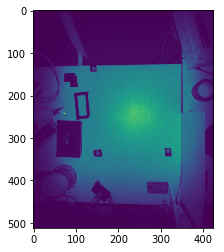

Prepared for Calibrate Capture?: yes
cali
{'radius': [8, 16], 'thresh': [85, 100]}
36
All Calibration points found


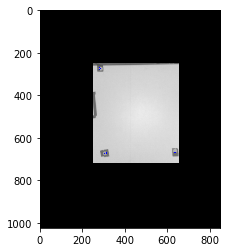

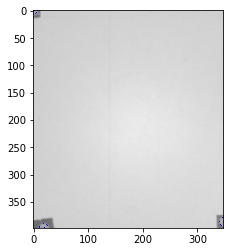

Continue?: yes
{'radius': [5, 8], 'thresh': [85, 220]}
30
All Calibration points found


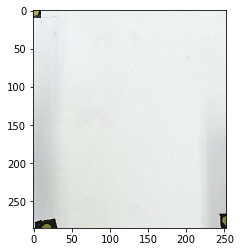

Continue?: yes
(174, 199)


In [218]:

calibrate_check1 = raw_input("Prepared for Empty Capture?: ")
if calibrate_check1 == "yes":
    print "empty"
    empt = kv.capture_frames()
    plt.imshow(empt['ir'])
    plt.show()
    empt_all = kv.prepare_im_array(empt)
    rgb, depth, ir = empt_all
    np.savez(os.path.join(PATH_TO_KINECT_IMAGES_DIR, 'im_array_empty_FINAL'), rgb=rgb, depth=depth, ir=ir)

calibrate_check2 = raw_input("Prepared for Calibrate Capture?: ")
if calibrate_check2 == "yes":
    cali = kv.capture_frames()
    print "cali"
    cali_all = kv.prepare_im_array(cali)
    rgb, depth, ir = cali_all

    np.savez(os.path.join(PATH_TO_KINECT_IMAGES_DIR, 'im_array_cal_FINAL'), rgb=rgb, depth=depth, ir=ir)

directory = PATH_TO_KINECT_IMAGES_DIR

cali = kv.load_npz_as_array("im_array_cal_FINAL", directory)
empt = kv.load_npz_as_array("im_array_empty_FINAL", directory)

empt_all = kv.prepare_im_array(empt)
cali_all = kv.prepare_im_array(cali)

rgb, depth, ir = empt_all
rgb, depth, ir = cali_all

depth_cali = run_calibration(empt_all, cali_all, adjust=True)

rgb_cali = run_calibration_rgb(empt_all, cali_all, depth_cali, adjust=True)

In [219]:
import copy

import cv2
from matplotlib import pyplot as plt
from object_data_csv import create_object_df, prepare_object_dict, add_to_csv, create_csv

##################################### Vision Imports ###########################################
import numpy as np
import os
import vision_tools as vt
from vision_tools import normclean2cv2
import kinect_vision as kv
from kinect_vision import PATH_TO_KINECT_IMAGES_DIR
from image_processing import run_calibration, run_calibration_rgb
from image_processing import run_image_processing_v2_depth, run_image_processing_v2_rgb

from tableObject_class import TableObject, match_rgb_with_depth, match_rgb_with_depth_v2
object_ipt_dict = {'cd':      [1,'rgb'],
                   'book':    [2,'rgb'],
                   'eraser':  [3,'rgb'],
                   'measure': [4,'depth'],
                   'box':     [5,'rgb'],
                   'mug':     [6,'depth'],
                   'torch':   [7,'depth'],
                   'tape':    [8,'depth'],
                   'banana':  [9,'depth'],
                   'ball':    [10,'depth']}


##################### Vision Initialise #####################################
directory = PATH_TO_KINECT_IMAGES_DIR

cali = kv.load_npz_as_array("im_array_cal_FINAL", directory)
empt = kv.load_npz_as_array("im_array_empty_FINAL", directory)

empt_all = kv.prepare_im_array(empt)
cali_all = kv.prepare_im_array(cali)

depth_cali = run_calibration(empt_all, cali_all, adjust=False)
rgb_cali = run_calibration_rgb(empt_all, cali_all, depth_cali, adjust=False)

{'radius': [8, 16], 'thresh': [85, 100]}
36
All Calibration points found
{'radius': [5, 8], 'thresh': [85, 220]}
30
All Calibration points found
(174, 199)


Ready?: yes


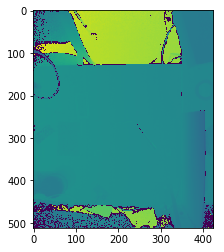

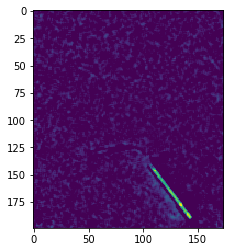

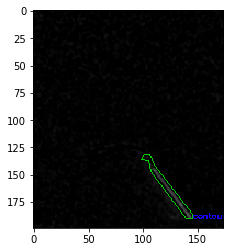

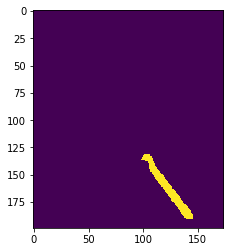

Depth Done
(174, 199)


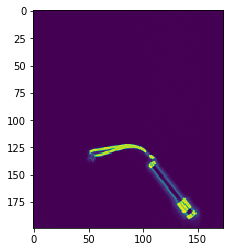

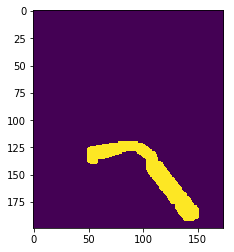

Making depth List ...
RGB data not considered
An exception of type AttributeError occurred. Arguments:
("'TableObject' object has no attribute 'rgb_box'",)
Making rgb object list...
Depth data not implemented
An exception of type AttributeError occurred. Arguments:
("'TableObject' object has no attribute 'box'",)
item
Length of depth and obj lists: 1 1
Matched based on Contour Overlap


True

In [220]:
while(1):
    capture_check = raw_input("Ready?: ")
    if capture_check == "yes":
        test = kv.capture_frames()
        test_all = kv.prepare_im_array(test)
        break

######## Process Test Image and Retrieve Depth and Contour Information from Depth and RGB Data ##########

rgb, depth, ir = test_all


normclean, sorted_family = run_image_processing_v2_depth(test_all, 
                                                         depth_cali, 
                                                         show=True)

rgbnormclean, rgb_family, test_rgbx_img = run_image_processing_v2_rgb(test_all, 
                                                                      rgb_cali, 
                                                                      depth_cali, 
                                                                      show=True)

######## Clean the images and convert them so that they are cv2 compatible ############

depth_normclean = normclean2cv2(normclean)
rgb_normclean = normclean2cv2(rgbnormclean)

#
test_rgb_img = vt.convert2rgb(test_rgbx_img)

cv2.imwrite("test_rgb_img.jpg", test_rgb_img)

####### Create List of Objects and match the rgb and depth data ##########
# Note that the label here is False which means that depth profiles will be overlaid with their 
# rgb counterparts objects will be labelled based on their spatial distances

obj_list = match_rgb_with_depth_v2(sorted_family, rgb_family, depth_normclean, test_rgb_img, label=False)

object_list = copy.copy(obj_list)

#for item in object_list.keys():
#    if object_list[item].height[0] == 0:
         #if abs(object_list[item].rgb_area - 3*obj_features_mean.rgb_area.book)/obj_features_std.rgb_area.book > 1:
                        #print "TOO SMALL/BIG TO BE BOOK"
                        #del object_list[item]
#                    if object_list[item].name != 'cd':
#                        print "TO BE DELETED: ",item, object_list[item].name
#                        del object_list[item]

#cv2.imwrite("test_rgb_img.jpg", test_rgb_img)
cv2.imwrite("depth_normclean.jpg", depth_normclean)

In [221]:
object_list = copy.copy(obj_list)

In [222]:
import object_recognition_tools as ort

excluded_val = ['centre', 'rgb_centre', 'number of children']
extras = ['R','G','B', 'centre_offset']

obj_features_mean, obj_features_std = ort.prepare_obj_features_param(obj_feat_csv = 'object_features.csv', 
                                                                 excluded_val = excluded_val, 
                                                                 extras=extras)

rec_df = ort.prepare_pick_obj_features_param(object_list, excluded_val, extras)
cost_list = ort.create_cost_list(obj_features_mean, obj_features_std, rec_df)
object_list = ort.label_object_list(object_list, cost_list, test_rgb_img, show=False)
print len(object_list)

for item in object_list.keys():
    if object_list[item].height[1] == 0:
        print object_list[item].height
        if object_list[item].name != 'cd':
            print "TO BE DELETED: ",item, object_list[item].name
            del object_list[item]

pick_obj = object_list.values()[0]

print "==========================================="
print "        OBJECT IS: ", pick_obj.name
print "==========================================="

print "####~~~~~~~~#######~~~~~~~~######"
print [item.name for item in object_list.values()]

ipt = object_ipt_dict[pick_obj.name][0]
if object_ipt_dict[pick_obj.name][1] == 'rgb':
    x_pix = pick_obj.rgb_centre[0]
    y_pix = pick_obj.rgb_centre[1]
else:
    x_pix = pick_obj.centre[0]
    y_pix = pick_obj.centre[1]

print "~~~~~~~~~~~~~~ OBJECT ATTRIBUTES ~~~~~~~~~~~~~~~"
print "Height:       ", pick_obj.height


print "RGB Aspect:   ", pick_obj.rgb_aspect
try:
    print "Circularness: ", pick_obj.circularness
except:
    print "no depth"

circles = depth_cali[4]
cali_circles_init = circles-circles[0][0]
cali_circles=[]
for circ in cali_circles_init[0]:
    cali_circles.append([circ[0]/2, circ[1]/2])
print x_pix, y_pix
print cali_circles

p=[x_pix,y_pix]

plt.figure("Circles")
cv2.circle(test_rgb_img,(int(x_pix),int(y_pix)),3,(0,0,255),1)
cv2.circle(test_rgb_img,(int(x_pix),int(y_pix)),2,(0,0,255),1)
plt.imshow(test_rgb_img)
#plt.show()
cv2.imwrite("test_rgb_img_centre.jpg", test_rgb_img)

1
Index([u'torch', u'mug'], dtype='object', name=u'name')
NAME:  torch
item
1
        OBJECT IS:  torch
####~~~~~~~~#######~~~~~~~~######
['torch']
~~~~~~~~~~~~~~ OBJECT ATTRIBUTES ~~~~~~~~~~~~~~~
Height:        (0.02545077, 0.081056237, 0.33824176, 0.0)
RGB Aspect:    0.343433985876
Circularness:  0.105652218701
123.0 160.5
[[0.0, 0.0], [9.5, 199.0], [174.0, 193.0]]


True

In [223]:
import grasping_points as gp
print pick_obj.name
first_node, node1, node2 = gp.first_grasping_point(pick_obj)

torch


In [224]:
a = {}
len(a)

0

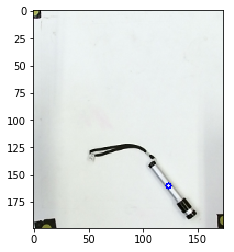

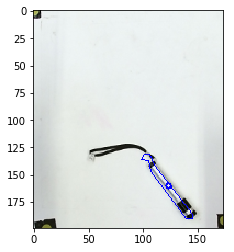

CURRENT_LINE:  [1.0, -0.7441860465116279]
[array([107, 147]), array([139, 190])]
POSSIBLE PAIRS [[array([145, 186]), array([110, 141])]]


In [225]:
checkcheck=0
for member in pick_obj.nuclear:
    out = cv2.drawContours(test_rgb_img, member['contour'], -1, (0+checkcheck*150,0+checkcheck*255,255+checkcheck*-255), 1)

plt.figure()
plt.imshow(out)
plt.show()

current_line = gp.find_perpendicular_line(node1, node2[0])
print "CURRENT_LINE: ", current_line
if pick_obj.name=='ball':
    current_line = np.array(first_node)-np.array(pick_obj.centre)
    print "new_current_line: ", current_line

possible_pairs = gp.find_possible_cross_pairs(pick_obj, first_node, current_line)
possible_pairs = gp.remove_duplicates(possible_pairs, node1, node2[0])

print "POSSIBLE PAIRS", possible_pairs

'''def find_second_grasping_point(possible_pairs, first_node, table_object):
    possible_second_node = []
    for pair in possible_pairs:
        dist, nearest = gp.pnt2line(first_node, pair[0], pair[1])
        possible_second_node.append([p for p in nearest])
    actual_grasp_centre = []
    
    remove_snode = []
    for num_snode, snode in enumerate(possible_second_node):
        node_separation = snode-first_node
        grasp_centre = first_node + node_separation/2
        
        grasp_node1 = first_node - node_separation*0.02
        grasp_node2 = snode + node_separation* 0.02
        grasp_gen = {}
        for gnum, grasp_point in enumerate([grasp_node1, grasp_centre, grasp_node2]):
            grasp_gen[gnum] = gp.find_point_generation(grasp_point, table_object.nuclear)
        
        if grasp_gen[0]!=grasp_gen[2]:
            remove_snode.append(num_snode)
        elif grasp_gen[1]<grasp_gen[0]:
            remove_snode.append(num_snode)
        else:
            actual_grasp_centre.append(grasp_centre)
            plt.figure()
            another_img = cv2.circle(copy.copy(test_rgb_img),
                                 (int(grasp_node1[0]),int(grasp_node1[1])),2,(255,0,0),3)
            another_img = cv2.circle(copy.copy(another_img),
                                 (int(grasp_node2[0]),int(grasp_node2[1])),2,(0,255,0),3)
            another_img = cv2.circle(copy.copy(another_img),
                                 (int(grasp_centre[0]),int(grasp_centre[1])),2,(0,0,255),3)
            plt.imshow(another_img)
            plt.show()
    
    for i in list(reversed(remove_snode)):
        possible_second_node.pop(i)
    
    return possible_second_node, actual_grasp_centre'''


possible_second_node, possible_grasp_centre = gp.find_second_grasping_point(possible_pairs, 
                                                                            first_node, 
                                                                            pick_obj)





second_node, grasp_centre = gp.determine_best_grasping_point(possible_second_node, possible_grasp_centre, first_node)

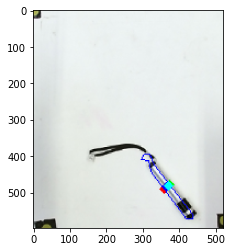

In [226]:
gp.display_grasping_points(test_rgb_img, first_node, second_node, grasp_centre, pick_obj, show=True)

WRONG 2


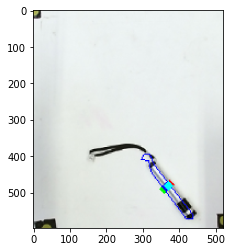

In [227]:
def fix_torch_orientation(table_object, rgb_normclean, fnode, snode):
    first_node = copy.copy(fnode)
    second_node = copy.copy(snode)
    
    box = cv2.minAreaRect(table_object.contour[0])
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    box_points = order_points(box)
    
    # Make the first two and last two entries the shorter edges
    if cdist([box_points[0]], [box_points[1]])>cdist([box_points[1]], [box_points[2]]):
        box_points = np.roll(box_points, 2)
    
    half_vect = (box_points[1]-box_points[2])/2
    half_points = np.append([(box_points[1]+box_points[2])/2], [(box_points[3]+box_points[0])/2], axis=0)
    
    box1_limits = half_points[::-1]+half_vect*1.3
    box2_limits = half_points-half_vect*1.3
    
    np.clip(box1_limits, [0,0], [np.shape(test_img)[0], np.shape(test_img)[1]], out=box1_limits)
    np.clip(box2_limits, [0,0], [np.shape(test_img)[0], np.shape(test_img)[1]], out=box2_limits)
    
    box1 = np.append(box1_limits, half_points, axis=0).astype("int")
    box2 = np.append(half_points[::-1], box2_limits, axis=0).astype("int")
    
    norm_half_vect = half_vect/np.sqrt(np.sum(half_vect**2))
                                       
    grasp_matrix = np.matrix([[norm_half_vect[1], norm_half_vect[0]], 
                             [-norm_half_vect[0], norm_half_vect[1]]])
    
    mask1 = vt.create_contour_mask([box1], test_img)
    mask2 = vt.create_contour_mask([box2], test_img)

    box1_avg = np.mean(test_img[mask1==255])
    box2_avg = np.mean(test_img[mask2==255])
    
    first_check=first_node*grasp_matrix
    second_check=second_node*grasp_matrix
    if box1_avg>box2_avg:
        if first_check[0,0]>second_check[0,0]:
            print "TORCH GRASP CORRECT 1"
        else:
            print "TORCH GRASP WRONG 1"
            first_node = snode
            second_node = fnode
    else:
        if first_check[0,0]<second_check[0,0]:
            print "TORCH GRASP CORRECT 2"
        else:
            print "TORCH GRASP WRONG 2"
            first_node = snode
            second_node = fnode
            
    return first_node, second_node



f_node, s_node = fix_torch_orientation(pick_obj, rgb_normclean, first_node, second_node)
gp.display_grasping_points(test_rgb_img, f_node, s_node, grasp_centre, pick_obj, show=True)

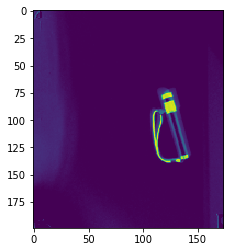

BOX_POINTS:  [[ 128.   92.]
 [ 140.  135.]
 [ 133.  136.]
 [ 122.   94.]]
IMCOMING
BOX_POINTS:  [[ 122.   94.]
 [ 128.   92.]
 [ 140.  135.]
 [ 133.  136.]]
HALF_VECT:  [ -6.  -21.5]
[[ 134.   113.5]
 [ 127.5  115. ]]
LIMITES
[[ 119.69999695   87.05000305]
 [ 126.19999695   85.55000305]]
BOX 1:
[[119  87]
 [126  85]
 [134 113]
 [127 115]]
BOX 2:
[[127 115]
 [134 113]
 [141 141]
 [135 142]]
NORM HALF VECT:  [-0.26879898 -0.96319634]
-0.268799
FIRST:  [ 128.30732484  115.64490446] [[ -92.4999133  -145.87762607]]
SECOND:  [134.27428229883378, 113.98741627580165] [[ -98.69279599 -145.88505158]]


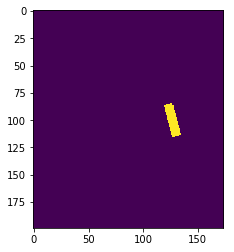

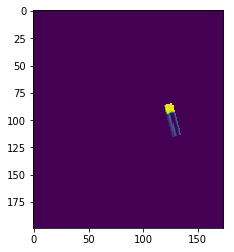

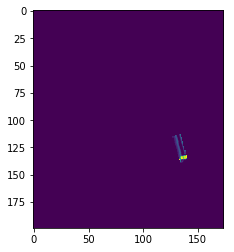

86.4637096774 42.2072072072
CORRECT 1


In [208]:
plt.imshow(rgb_normclean)
plt.show()

test_img = copy.copy(rgb_normclean)

box = cv2.minAreaRect(pick_obj.contour[0])
box = cv2.boxPoints(box)
box = np.array(box, dtype="int")
box_points = order_points(box)
print "BOX_POINTS: ", box_points
#print box_points
if cdist([box_points[0]], [box_points[1]])>cdist([box_points[1]], [box_points[2]]):
    print "IMCOMING"
    box_points = np.roll(box_points,2)
    
print "BOX_POINTS: ", box_points
#print box_points
half_vect = (box_points[1]-box_points[2])/2
print "HALF_VECT: ", half_vect
half_points = np.append([(box_points[1]+box_points[2])/2], [(box_points[3]+box_points[0])/2], axis=0)
print half_points
box1_limits = half_points[::-1]+half_vect*1.3
box2_limits = half_points-half_vect*1.3
print "LIMITES"
print box1_limits

np.clip(box1_limits, [0,0], [np.shape(test_img)[0], np.shape(test_img)[1]], out=box1_limits)
np.clip(box2_limits, [0,0], [np.shape(test_img)[0], np.shape(test_img)[1]], out=box2_limits)

box1 = np.append(box1_limits,half_points, axis=0).astype("int")
print "BOX 1:"
print box1
box2 = np.append(half_points[::-1], box2_limits, axis=0).astype("int")
print "BOX 2:"
print box2

norm_half_vect = half_vect/np.sqrt(np.sum(half_vect**2))#
print "NORM HALF VECT: ", norm_half_vect

print norm_half_vect[0]

grasp_matrix = np.matrix([[norm_half_vect[1], norm_half_vect[0]], 
                         [-norm_half_vect[0], norm_half_vect[1]]])

print "FIRST: ", first_node, first_node*grasp_matrix
print "SECOND: ", second_node,second_node*grasp_matrix

mask1 = vt.create_contour_mask([box1], test_img)
mask2 = vt.create_contour_mask([box2], test_img)

mask = cv2.dilate(mask1, None, iterations=2)

box1_avg = np.mean(test_img[mask1==255])
box2_avg = np.mean(test_img[mask2==255])
#mask = vt.create_contour_mask(pick_obj.contour, test_img)

out = np.zeros_like(test_img)
out[mask1==255] = test_img[mask1==255]
plt.figure()
plt.imshow(mask1)
plt.show()
plt.figure()
plt.imshow(out)
out = np.zeros_like(test_img)
out[mask2==255] = test_img[mask2==255]
plt.figure()
plt.imshow(out)
plt.show()

print box1_avg, box2_avg

first_check=first_node*grasp_matrix
second_check=second_node*grasp_matrix
if box1_avg>box2_avg:
    if first_check[0,0]>second_check[0,0]:
        print "CORRECT 1"
    else:
        print "WRONG 1"
else:
    if first_check[0,0]<second_check[0,0]:
        print "CORRECT 2"
    else:
        print "WRONG 2"


In [180]:
from scipy.spatial.distance import cdist
import numpy as np
import cv2
 
test_pnts = copy.copy(box_points)
def order_points(pts):
    pts = pts[np.argsort(pts[:,0])]
    left_pts = pts[:2][np.argsort(pts[:2][:,1])]
    tl = left_pts[0]
    bl = left_pts[1]
    right_pts = pts[2:4][np.argsort(pts[2:4][:,1])]
    tr = right_pts[0]
    br = right_pts[1]
    return np.array([tl, tr, br, bl], dtype="float32")
    
    #top = pts[0]
    #right = pts[np.argsort(pts[])]
    
    
    
    #xSorted = pts[np.argsort(pts[:, 0]), :]
 
    #leftMost = xSorted[:2, :]
    #rightMost = xSorted[2:, :]
 
    #leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    #(tl, bl) = leftMost

    #D = cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    #(br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    #return np.array([tl, tr, br, bl], dtype="float32")
    # Sort so that circle points ordered clockwise from top left
        #circles_sorted[0] = circles[0][np.argsort(circles[0][:,1])]
        #print (circles_sorted[0])
        #circles_sorted[0][1:] = circles_sorted[0][1:][np.argsort(circles_sorted[0][1:][:,0])]

order_points(test_pnts)

array([[  76.,   70.],
       [ 120.,   96.],
       [ 115.,  103.],
       [  72.,   76.]], dtype=float32)

In [207]:
tt = copy.copy(box1_limits)
print np.shape(test_img)

np.clip(tt, [0,0], [np.shape(test_img)[0], np.shape(test_img)[1]], out=tt)


(199, 174)


array([[ 119.69999695,   87.05000305],
       [ 126.19999695,   85.55000305]], dtype=float32)